In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# 내 드라이브 폴더 (이미지 넣어둔 경로로 수정)
IMG_DIR = "/content/drive/MyDrive/curator_images"


Mounted at /content/drive


In [ ]:
# PyTorch (CUDA 12.1) + HuggingFace + BitsAndBytes
!pip -q install torch torchvision --index-url https://download.pytorch.org/whl/cu121
!pip -q install transformers accelerate pillow bitsandbytes


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 41.4 MB/s eta 0:00:00


In [ ]:
import torch
from transformers import (
    CLIPProcessor, CLIPModel,
    Blip2Processor, Blip2ForConditionalGeneration,
    BitsAndBytesConfig
)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("CUDA:", torch.cuda.is_available())

# ===== CLIP (ViT-L/14: 속도/성능 균형) =====
clip_id    = "openai/clip-vit-large-patch14"
clip_model = CLIPModel.from_pretrained(
    clip_id, torch_dtype=torch.float16 if device=="cuda" else None
).to(device)
clip_proc  = CLIPProcessor.from_pretrained(clip_id)

# ===== BLIP-2 (OPT-2.7B: 경량 & 빠름) =====
bnb = BitsAndBytesConfig(load_in_8bit=True)
blip2_id   = "Salesforce/blip2-opt-2.7b"
iblip_proc  = Blip2Processor.from_pretrained(blip2_id)
iblip_model = Blip2ForConditionalGeneration.from_pretrained(
    blip2_id,
    quantization_config=bnb,
    device_map="auto"
)

print("Models loaded:", clip_id, "+", blip2_id)


CUDA: True


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/882 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

Models loaded: openai/clip-vit-large-patch14 + Salesforce/blip2-opt-2.7b


In [ ]:
# ===== Master Taxonomy for Museum/Artwork Keywords =====

# 0) Scene/Medium Gate (coarse)
SCENE_CLASSES = [
  "portrait painting", "landscape painting", "landscape photograph",
  "cityscape photograph", "architecture photograph",
  "still life painting", "abstract painting", "figure study",
  "sculpture (indoor)", "installation (indoor)", "museum wall text", "indoor gallery view"
]
SCENE_TEMPLATES = ["a {label}", "an image of {label}", "artwork showing {label}", "a photo of {label}"]

# 1) Visual-only (Safe) Categories
TAXONOMY_VISUAL = {
  "subject": [
    "portrait","single person","group of people","figure study","profile","three-quarter view","front-facing",
    "open field","rolling hill","mountain range","seascape","city skyline","street view","architecture facade",
    "still life","flowers","fruit","animal","interior","night scene","clouds","sun","moon"
  ],
  "composition": [
    "centered composition","rule of thirds","diagonal thrust","symmetry","asymmetry",
    "low horizon","high horizon","wide view","close-up","cropped edges","negative space",
    "balanced framing","sweeping curve","gentle slope","overlapping forms"
  ],
  "color": [
    "vivid green","blue sky","warm tones","cool tones","earth tones","neutral palette",
    "high contrast","low contrast","saturated colors","muted colors","limited palette","monochrome",
    "complementary contrast","analogous harmony"
  ],
  "lighting": [
    "soft lighting","hard lighting","backlighting","rim lighting","spotlit","even lighting","natural light","artificial light"
  ],
  "texture": [
    "fine brushwork","visible brushwork","smooth shading","soft edges","hard edges","polished surface",
    "impasto","glazing","stippled","dry brush","drips","collaged surface","cracked surface","matte finish","glossy finish"
  ],
  "space": [
    "shallow space","deep space","flatness","linear perspective","atmospheric perspective","overhead view","eye-level view","low angle"
  ],
  "format": [
    "miniature scale","intimate scale","medium scale","large scale","monumental scale",
    "vertical format","horizontal format","square format","diptych","triptych","multi-panel"
  ],
  "mood": [
    "serene","quiet","contemplative","uplifting","fresh","expansive","mysterious",
    "dramatic","somber","playful","tense","melancholic","austere","joyful"
  ]
}

# 2) Contextual (OFF by default) — 메타가 있을 때만 사용
TAXONOMY_CONTEXT = {
  # medium: 넓은 표현 매체 계열
  "medium": [
    "oil painting","acrylic painting","watercolor","photography","drawing",
    "printmaking","collage","sculpture","installation","digital art","mixed media"
  ],
  # support: 지지체/재료
  "support": [
    "canvas","paper","wood","panel","linen","metal","stone","fabric",
    "ceramic","glass","resin","aluminum"
  ],
  # technique: 세부 공정(필요 시)
  "technique": [
    "etching","lithograph","screenprint","woodcut","collage","assemblage","found objects"
  ],
  # style: (선택) — 이미지 단독 추정은 위험, 기본 OFF
  "style": [
    "realism","impressionist style","expressionist style","cubist style","surreal style",
    "minimal style","abstract geometric","abstract gestural","pop style","conceptual tendency"
  ]
}

# 3) 동의어 정규화 (aliases)
ALIASES = {
  "portraiture": "portrait",
  "head-and-shoulders": "portrait",
  "frontal": "front-facing",
  "skyline": "city skyline",
  "landscape": "open field",
  "hill": "rolling hill",
  "high key": "bright light",
  "low key": "low contrast",
  "mono": "monochrome",
  "bw":"monochrome", "black and white":"monochrome",
  "blue skies": "blue sky",
  "brushy":"visible brushwork", "thick paint":"impasto",
  "triptych panel":"triptych"
}

# 4) 상호배타 규칙 (Mutual Exclusivity)
EXCLUSIVE_GROUPS = {
  "subject": [
    ["single person","group of people"],
    ["portrait","still life","open field","city skyline","seascape","architecture facade","interior","animal","flowers","fruit"],
  ],
  "composition": [
    ["symmetry","asymmetry"], ["low horizon","high horizon"], ["wide view","close-up"]
  ],
  "color": [
    ["high contrast","low contrast"], ["saturated colors","muted colors"], ["monochrome","complementary contrast","analogous harmony"]
  ],
  "lighting": [
    ["soft lighting","hard lighting"], ["natural light","artificial light"], ["backlighting","spotlit","even lighting"]
  ],
  "texture": [
    ["fine brushwork","visible brushwork","impasto","glazing","stippled","dry brush","polished surface","matte finish","glossy finish"]
  ],
  "space": [
    ["flatness","deep space","shallow space"], ["overhead view","eye-level view","low angle"]
  ],
  "format": [
    ["miniature scale","intimate scale","medium scale","large scale","monumental scale"],
    ["vertical format","horizontal format","square format"], ["diptych","triptych","multi-panel"]
  ],
  "mood": [
    ["serene","dramatic","tense"], ["joyful","somber","melancholic","austere"]
  ]
}

# 5) CLIP 라벨셋
CLIP_LABELS_PAINTING = {
  "subject": [x for x in TAXONOMY_VISUAL["subject"]],
  "composition": [x for x in TAXONOMY_VISUAL["composition"]],
  "color": [x for x in TAXONOMY_VISUAL["color"]],
  "lighting": [x for x in TAXONOMY_VISUAL["lighting"]],
  "texture": [x for x in TAXONOMY_VISUAL["texture"]],
  "space": [x for x in TAXONOMY_VISUAL["space"]],
  "format": [x for x in TAXONOMY_VISUAL["format"]],
  "mood": [x for x in TAXONOMY_VISUAL["mood"]],
}

CLIP_LABELS_LANDSCAPE = {
  "subject": ["open field","rolling hill","mountain range","seascape","city skyline","clouds","grass","wide sky","distant horizon"],
  "composition": ["wide view","low horizon","high horizon","gentle slope","sweeping curve","negative space","centered composition","rule of thirds"],
  "color": ["vivid green","blue sky","natural palette","bright light","soft light","high contrast","low contrast","muted colors"],
  "lighting": ["natural light","soft lighting","hard lighting","backlighting","even lighting"],
  "texture": ["soft grass","crisp clouds","smooth gradient","clear air","fine details","soft edges"],
  "space": ["deep space","atmospheric perspective","eye-level view","low angle"],
  "format": ["horizontal format","panoramic format" if "panoramic format" in TAXONOMY_VISUAL.get("format",[]) else "horizontal format"],
  "mood": ["tranquil","fresh","expansive","calm","uplifting","serene"]
}

# 6) 프롬프트 템플릿
CLIP_TEMPLATES_PAINTING = ["a painting of {label}","artwork showing {label}"]
CLIP_TEMPLATES_PHOTO    = ["a photo of {label}","an image of {label}"]
PER_CAT_TOPK = 2

# 7) 컨텍스트 스위치(기본 OFF) — 사용자 메타 있을 때만 True로 켬
ENABLE_CONTEXTUAL = False


In [ ]:
# ===== (Refined) 5번 셀: Utils → Gate → CLIP Taxonomy → BLIP JSON → Curator Text =====
import os, glob, re, json, random
from PIL import Image
from IPython.display import display
import torch, numpy as np

# ---------- helpers ----------
def list_images(img_dir):
    paths = []
    for ext in ("*.jpg","*.jpeg","*.png","*.webp","*.bmp"):
        paths += glob.glob(os.path.join(img_dir, ext))
    return sorted(paths)

def norm_label(s: str):
    s0 = s.strip().lower()
    return ALIASES.get(s0, s0)

def apply_exclusive(selected: dict):
    """카테고리별 EXCLUSIVE_GROUPS 규칙 적용(선택 순서 보존)"""
    for cat, groups in EXCLUSIVE_GROUPS.items():
        if cat not in selected: continue
        vals = selected[cat]
        keep = []
        for v in vals:
            conflict = False
            for g in groups:
                if v in g and any(x in keep for x in g):
                    conflict = True; break
            if not conflict:
                keep.append(v)
        selected[cat] = keep
    return selected

# ---------- scene gate ----------
@torch.no_grad()
def clip_scene_gate(image: Image.Image):
    texts, idx = [], []
    for i, lab in enumerate(SCENE_CLASSES):
        for t in SCENE_TEMPLATES:
            texts.append(t.format(label=lab)); idx.append(i)

    inputs = clip_proc(text=texts, images=image, return_tensors="pt", padding=True).to(device)
    out = clip_model(**inputs)
    probs = out.logits_per_image.softmax(dim=1)[0].detach().float().cpu().numpy()

    scores = np.zeros(len(SCENE_CLASSES), dtype=np.float32)
    cnt    = np.zeros(len(SCENE_CLASSES), dtype=np.float32)
    for p, i in zip(probs, idx):
        scores[i] += p; cnt[i] += 1
    scores = scores / np.maximum(cnt, 1e-6)

    top_i = int(scores.argmax()); top_label = SCENE_CLASSES[top_i]; conf = float(scores[top_i])
    if "landscape" in top_label or "photograph" in top_label:
        mode = "landscape"
    elif "sculpture" in top_label or "installation" in top_label:
        mode = "object"
    else:
        mode = "painting"
    return mode, top_label, conf

# ---------- CLIP keywording (원본 로직 유지) ----------
@torch.no_grad()
def clip_keywords_taxonomic(image: Image.Image, mode: str, per_cat_topk: int = PER_CAT_TOPK):
    if mode == "landscape":
        label_bank = CLIP_LABELS_LANDSCAPE
        tmpls = CLIP_TEMPLATES_PHOTO
    else:
        label_bank = CLIP_LABELS_PAINTING
        tmpls = CLIP_TEMPLATES_PAINTING

    cat2scores = {c: {} for c in label_bank.keys()}
    for cat, labs in label_bank.items():
        texts, base = [], []
        for i, lab in enumerate(labs):
            lab_n = norm_label(lab)
            for t in tmpls:
                texts.append(t.format(label=lab_n)); base.append(i)
        inputs = clip_proc(text=texts, images=image, return_tensors="pt", padding=True).to(device)
        out = clip_model(**inputs)
        probs = out.logits_per_image.softmax(dim=1)[0].detach().float().cpu().numpy()
        acc = np.zeros(len(labs), dtype=np.float32); cnt = np.zeros(len(labs), dtype=np.float32)
        for p, bi in zip(probs, base): acc[bi]+=p; cnt[bi]+=1
        avg = acc/np.maximum(cnt,1e-6)

        rank = sorted(zip(labs, avg), key=lambda x:-x[1])[:per_cat_topk]
        for lab, sc in rank:
            lab_n = norm_label(lab)
            cat2scores[cat][lab_n] = float(sc)

    selected = {cat: [k for k,_ in sorted(d.items(), key=lambda x:-x[1])] for cat,d in cat2scores.items()}
    return apply_exclusive(selected)

# ---------- Safety & BLIP JSON ----------
BANNED_WORDS = [
    "http","https","www",".com",".co",".net",".org",".io",".ai","sale","sold","price","discount","auction","shipping"
]
_bad_ids = [iblip_proc.tokenizer(w, add_special_tokens=False).input_ids for w in BANNED_WORDS]
_bad_ids += [iblip_proc.tokenizer(" "+w, add_special_tokens=False).input_ids for w in BANNED_WORDS]
_bad_ids = [ids for ids in _bad_ids if len(ids)>0]

# ---------- 사용자 메타(재료·기법만; 국가·크기 제외) ----------
# user_meta 예시:
# user_meta = {
#   "materials": ["Canvas","Resin"],
#   "technique": ["Digital Art"]
# }
_MATERIAL_MAP = {
    "canvas":"canvas","paper":"paper","wood":"wood","panel":"panel","linen":"linen",
    "metal":"metal","stone":"stone","fabric":"fabric","ceramic":"ceramic",
    "glass":"glass","resin":"resin","aluminum":"aluminum"
}
_TECHNIQUE_TO_MEDIUM = {
    "oil painting":"oil painting", "acrylic painting":"acrylic painting",
    "watercolor":"watercolor","photography":"photography","drawing":"drawing",
    "printmaking":"printmaking","collage":"collage","sculpture":"sculpture",
    "installation":"installation","digital art":"digital art","mixed media":"mixed media"
}
def _norm_tokens(xs):
    out = []
    for x in xs or []:
        if not isinstance(x, str): continue
        out.append(norm_label(x))
    return out

def inject_user_meta_into_features(features: dict, user_meta: dict):
    """BLIP 결과(features)에 사용자 지정 메타(재료·기법) 주입. 국가/크기는 무시."""
    if not user_meta:
        return features

    # materials → support
    mats = _norm_tokens(user_meta.get("materials"))
    supp_add = []
    for m in mats:
        key = _MATERIAL_MAP.get(m, m)
        if key in TAXONOMY_CONTEXT["support"]:
            supp_add.append(key)

    # technique → medium 우선, 없으면 technique
    techs = _norm_tokens(user_meta.get("technique"))
    med_add, tec_add = [], []
    for t in techs:
        if t in TAXONOMY_CONTEXT["medium"]:
            med_add.append(t)
        elif t in TAXONOMY_CONTEXT["technique"]:
            tec_add.append(t)
        elif t in _TECHNIQUE_TO_MEDIUM:
            med_add.append(_TECHNIQUE_TO_MEDIUM[t])

    if supp_add:
        features["support"] = list(dict.fromkeys(supp_add + features.get("support", [])))[:2]
    if med_add:
        features["medium"] = list(dict.fromkeys(med_add + features.get("medium", [])))[:2]
    if tec_add:
        features["technique"] = list(dict.fromkeys(tec_add + features.get("technique", [])))[:2]

    return features

def _allowed_vocab_for_mode(mode: str):
    """
    허용어 = TAXONOMY_VISUAL ∪ (모드별 CLIP 라벨셋)
    → landscape 전용 라벨(soft grass, clear air, natural palette, bright light 등)도 허용.
    """
    allowed = {k: set(v) for k, v in TAXONOMY_VISUAL.items()}
    extra_bank = CLIP_LABELS_LANDSCAPE if mode == "landscape" else CLIP_LABELS_PAINTING
    for cat, labs in extra_bank.items():
        if cat in allowed:
            allowed[cat].update(norm_label(x) for x in labs)
        else:
            allowed[cat] = set(norm_label(x) for x in labs)
    return allowed

def build_blip_prompt_with_user_meta(clip_selected: dict, enable_contextual: bool, user_meta: dict):
    """BLIP 프롬프트에 사용자 메타(재료·기법) 힌트 추가. 국가/크기는 제외."""
    hints = []
    for cat, vals in clip_selected.items():
        hints += vals
    if user_meta:
        hints += _norm_tokens(user_meta.get("materials"))
        hints += _norm_tokens(user_meta.get("technique"))

    ctx = ("Observed: " + ", ".join(hints) + ". ") if hints else ""
    prompt = (
        f"{ctx}"
        "Return ONLY a JSON with keys: "
        "\"subject\",\"composition\",\"color\",\"lighting\",\"texture\",\"space\",\"format\",\"mood\" "
        + (",\"medium\",\"support\",\"technique\",\"style\" " if enable_contextual else "")
        + "Each value is an array (up to 2 strings). "
        "Use EXACT phrases from the allowed sets. JSON only; no names/dates/URLs."
    )
    return prompt

@torch.no_grad()
def select_features_json(image, clip_selected: dict, mode="painting",
                         enable_contextual: bool = ENABLE_CONTEXTUAL, user_meta=None):
    # 0) 허용어 집합(모드 반영)
    allowed = _allowed_vocab_for_mode(mode)

    # 1) BLIP 프롬프트(시각 요소 + 사용자 메타 힌트)
    prompt = build_blip_prompt_with_user_meta(clip_selected, enable_contextual, user_meta or {})
    inputs = iblip_proc(images=image, text=prompt, return_tensors="pt")
    inputs = {k:(v.to(device) if hasattr(v,'to') else v) for k,v in inputs.items()}
    out = iblip_model.generate(
        **inputs, max_new_tokens=180, do_sample=False, no_repeat_ngram_size=3, bad_words_ids=_bad_ids
    )
    raw = iblip_proc.batch_decode(out, skip_special_tokens=True)[0].strip()

    # 2) 파싱 → 허용어 필터 → (비면) CLIP 힌트 보충 → 배타 규칙
    def robust(raw_text):
        try:
            data = json.loads(raw_text)
        except:
            m = re.search(r"\{.*\}", raw_text, flags=re.DOTALL)
            data = json.loads(m.group(0)) if m else {}
        clean = {}
        keys = ["subject","composition","color","lighting","texture","space","format","mood"]
        if enable_contextual:
            keys += ["medium","support","technique","style"]
        for cat in keys:
            vals = data.get(cat, [])
            if isinstance(vals, str): vals=[vals]
            vals = [norm_label(v) for v in vals if isinstance(v,str)]
            # 허용어 필터
            if cat in allowed:
                vals = [v for v in vals if v in allowed[cat]]
            elif enable_contextual and cat in TAXONOMY_CONTEXT:
                vals = [v for v in vals if v in TAXONOMY_CONTEXT[cat]]
            # 폴백: 비면 CLIP 힌트 → 그래도 비면 랜덤 1개
            if not vals:
                hint = [h for h in (clip_selected.get(cat, []) if clip_selected else []) if (cat in allowed and h in allowed[cat])]
                if hint:
                    vals = hint[:1]
                elif cat in allowed and len(allowed[cat]) > 0:
                    vals = [random.sample(list(allowed[cat]), 1)[0]]
            clean[cat] = vals[:2]
        return apply_exclusive(clean)

    feat = robust(raw)
    # 3) 사용자 메타 주입(국가/크기는 무시)
    feat = inject_user_meta_into_features(feat, user_meta or {})
    return feat

# ---------- Curator-style rendering ----------
def _hash_tags(feat: dict):
    def tagify(s):
        t = s.lower().replace(" ", "_")
        return "#" + re.sub(r"[^a-z0-9_]+","", t)
    src = []
    for k in ["subject","composition","color","lighting"]:
        src += feat.get(k, [])[:1]
    tags = " ".join(tagify(x) for x in src if x).strip()
    return tags or "#art #details"

def render_curator_text(feat: dict, mode: str = "painting", max_sentences: int = 4):
    # 공통 요소
    subj = feat.get("subject", [])
    comp = feat.get("composition", [])
    col  = feat.get("color", [])
    lit  = feat.get("lighting", [])
    tex  = feat.get("texture", [])
    spc  = feat.get("space", [])
    mood = feat.get("mood", [])

    # (추가) 컨텍스트: 재료/기법만 사용 (국가·크기 제외)
    med  = feat.get("medium", [])
    supp = feat.get("support", [])
    tecq = feat.get("technique", [])

    # 주제 표현 개선
    def _pretty_subject(subj_list):
        sset = set(subj_list)
        if "front-facing" in sset and "single person" in sset:
            return "a front-facing portrait of a single sitter"
        if "open field" in sset and "rolling hill" in sset:
            return "an open field with rolling hills"
        return ", ".join(subj_list) if subj_list else "its subject"

    # 1) 관찰 근거
    s1 = "This " + ("scene" if mode=="landscape" else "work") + " presents "
    s1 += _pretty_subject(subj)
    if comp: s1 += f", arranged with {', '.join(comp)}"
    if lit:  s1 += f" under {', '.join(lit)}"
    s1 += "."

    # 2) 색/표면
    bits = []
    if col:  bits.append(", ".join(col))
    if tex:  bits.append(", ".join(tex))
    s2 = "Color and surface set the tone: " + " and ".join(bits) + "." if bits else ""

    # 2b) 매체/지지체/기법
    mat_bits = []
    if med:  mat_bits.append(", ".join(med))
    if supp: mat_bits.append("on " + ", ".join(supp))
    if tecq and not med:
        mat_bits.append(", ".join(tecq))
    s2b = ("Executed in " + " ".join(mat_bits) + ".") if mat_bits else ""

    # 3) 공간/시선
    s3 = ""
    if spc: s3 = f"The sense of space ({', '.join(spc)}) guides how the eye moves across the image."

    # 4) 정서/경험 (문장 자연화)
    mtxt = ", ".join(mood) if mood else "quiet"
    s4 = f"It invites a {mtxt} gaze, letting the image unfold gradually."

    sentences = [s for s in [s1, s2, s2b, s3, s4] if s]
    return " ".join(sentences[:max_sentences]).strip() + "\n" + _hash_tags(feat)
# ---------- Subject enrichment ----------
def enrich_core_terms(features: dict, clip_selected: dict, mode: str):
    """
    subject가 1개 이하일 때, CLIP 상위 라벨에서 안전하게 1개 더 보충.
    """
    allowed = _allowed_vocab_for_mode(mode)
    subj = features.get("subject", [])[:]
    clip_subj = clip_selected.get("subject", []) if clip_selected else []

    if len(subj) < 2:
        priority = [
            ("rolling hill", "open field"),
            ("open field", "rolling hill"),
            ("front-facing", "single person"),
            ("portrait", "single person"),
        ]
        for a, b in priority:
            if a in subj and b in clip_subj and b not in subj and b in allowed.get("subject", set()):
                subj.append(b)
                break

        for cand in clip_subj:
            if len(subj) >= 2: break
            if cand not in subj and cand in allowed.get("subject", set()):
                subj.append(cand)

    features["subject"] = subj[:2]
    return features


Images found: 2


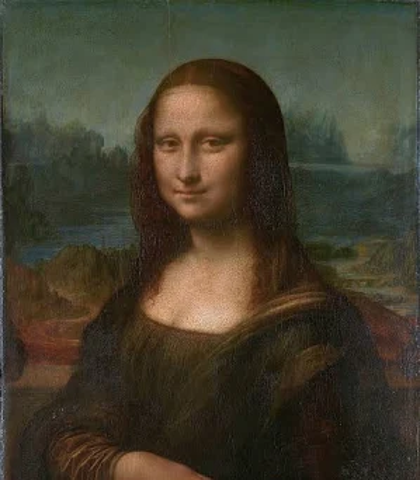


=== [1] images.webp ===
[SceneGate] mode=painting (portrait painting), conf=0.240
[CLIP (per-category)] {'subject': ['front-facing', 'single person'], 'composition': ['cropped edges', 'asymmetry'], 'color': ['neutral palette', 'low contrast'], 'lighting': ['even lighting', 'soft lighting'], 'texture': ['smooth shading', 'matte finish'], 'space': ['eye-level view'], 'format': ['horizontal format'], 'mood': ['serene']}
[Selected Features] {'subject': ['front-facing', 'single person'], 'composition': ['cropped edges'], 'color': ['neutral palette'], 'lighting': ['even lighting'], 'texture': ['smooth shading'], 'space': ['eye-level view'], 'format': ['horizontal format'], 'mood': ['serene']}
This work presents a front-facing portrait of a single sitter, arranged with cropped edges under even lighting. Color and surface set the tone: neutral palette and smooth shading. The sense of space (eye-level view) guides how the eye moves across the image. It invites a serene gaze, letting the image 

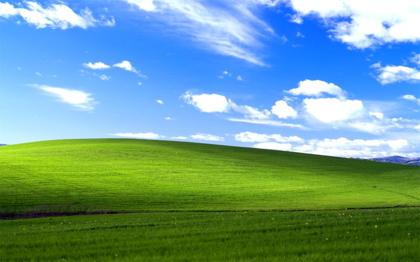


=== [2] windows_xp_bliss-wide.jpg ===
[SceneGate] mode=landscape (landscape photograph), conf=0.216
[CLIP (per-category)] {'subject': ['rolling hill', 'open field'], 'composition': ['high horizon'], 'color': ['vivid green', 'blue sky'], 'lighting': ['natural light', 'even lighting'], 'texture': ['clear air', 'soft grass'], 'space': ['atmospheric perspective', 'deep space'], 'format': ['horizontal format'], 'mood': ['tranquil', 'calm']}
[Selected Features] {'subject': ['rolling hill', 'open field'], 'composition': ['high horizon'], 'color': ['vivid green'], 'lighting': ['natural light'], 'texture': ['clear air'], 'space': ['atmospheric perspective'], 'format': ['horizontal format'], 'mood': ['tranquil']}
This scene presents an open field with rolling hills, arranged with high horizon under natural light. Color and surface set the tone: vivid green and clear air. The sense of space (atmospheric perspective) guides how the eye moves across the image. It invites a tranquil gaze, letting t

In [ ]:
# === Run: Scene Gate → Taxonomic CLIP → Robust JSON (+user meta) → Curator text ===
img_paths = list_images(IMG_DIR)
print("Images found:", len(img_paths))
assert img_paths, "No images in IMG_DIR."

# (폼 등에서 받아온) 사용자 메타 예시 — 재료·기법만; 국가/크기는 아예 넣지마
user_meta = {
    # "materials": ["Canvas", "Resin"],
    # "technique": ["Digital Art"]
}

N = min(5, len(img_paths))
for i, p in enumerate(img_paths[:N], start=1):
    img = Image.open(p).convert("RGB")
    w = 420; h = int(img.height * (w / img.width))
    display(img.resize((w, h)))
    print(f"\n=== [{i}] {os.path.basename(p)} ===")

    # 0) 장르/매체 게이트
    mode, gate_label, conf = clip_scene_gate(img)
    print(f"[SceneGate] mode={mode} ({gate_label}), conf={conf:.3f}")

    # 1) CLIP 택사노미 라벨
    clip_selected = clip_keywords_taxonomic(img, mode=mode, per_cat_topk=PER_CAT_TOPK)
    print("[CLIP (per-category)]", clip_selected)

    # 2) BLIP-2 → 허용어 JSON (+ 사용자 메타 주입)
    enable_ctx = bool(user_meta.get("materials") or user_meta.get("technique"))
    features = select_features_json(
        img,
        clip_selected=clip_selected,
        mode=mode,
        enable_contextual=enable_ctx,
        user_meta=user_meta
    )
    features = enrich_core_terms(features, clip_selected, mode)
    print("[Selected Features]", features)

    # 3) 큐레이터 톤 렌더링 (국가/크기 제외, 재료/기법은 포함됨)
    if mode == "landscape":
        desc = render_curator_text(features, mode="landscape", max_sentences=4)
    else:
        desc = render_curator_text(features, mode="painting", max_sentences=4)

    # 간단한 금칙어 2차 제거(안전망)
    for w in ["http","https",".com",".co",".net",".org","auction","price","sold","shipping"]:
        desc = re.sub(rf"\b{re.escape(w)}\b","",desc, flags=re.IGNORECASE)

    print(desc, "\n")
